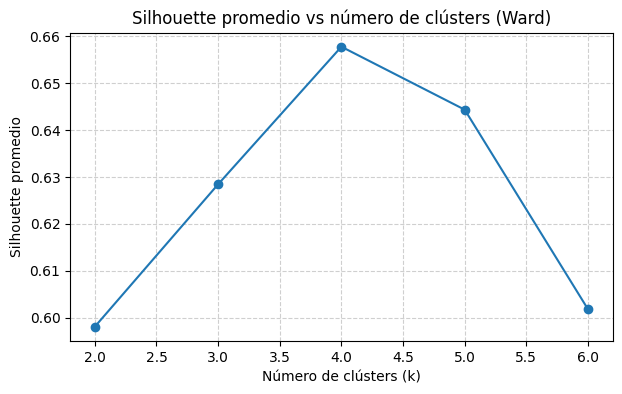

✅ Mejor número de clústers según silhouette: k = 4


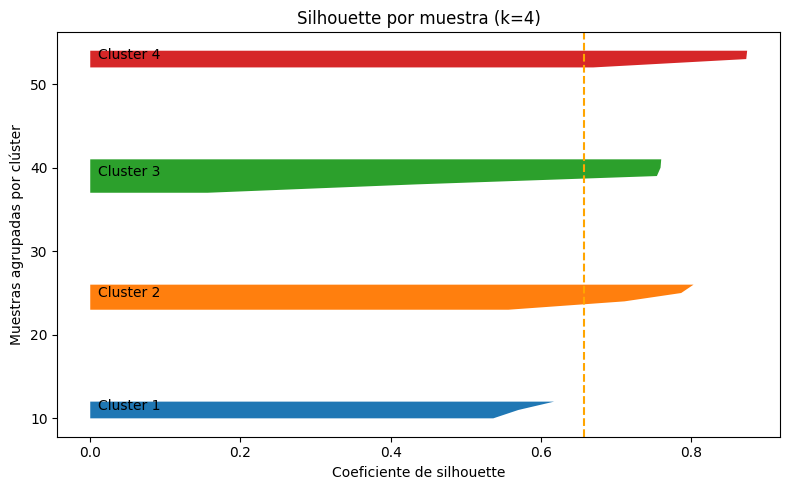


Archivo guardado: clusters_con_silhouette.csv
   estacion  poblacion_2km  cluster  silhouette
9       NTE         102429        1    0.536788
6        NE         105412        1    0.617803
10       NO         129539        1    0.570109
2       NE3           8891        2    0.711441
13      NO3          14672        2    0.803487
4       NE2          16510        2    0.787001
0       SE3          21053        2    0.556882
5       SUR          57242        3    0.156336
3        SE          68557        3    0.754667
1       SE2          68913        3    0.760450
12       SO          71818        3    0.759541
14      NO2          83200        3    0.433783
8        CE          34246        4    0.669910
11      SO2          40465        4    0.874898
7      NTE2          40547        4    0.873682


In [ ]:
# Requisitos:
# pip install pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

df = pd.read_csv("poblacion_por_estacion_2km.csv")

X = df[['poblacion_2km']].values

ks = range(2, 7)
avg_sil = []

for k in ks:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    avg_sil.append(score)

plt.figure(figsize=(7, 4))
plt.plot(ks, avg_sil, marker='o')
plt.title('Silhouette promedio vs número de clústers (Ward)')
plt.xlabel('Número de clústers (k)')
plt.ylabel('Silhouette promedio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# elegir mejo k
best_k = ks[np.argmax(avg_sil)]
print(f"Mejor número de clústers según silhouette: k = {best_k}")


best_model = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
best_labels = best_model.fit_predict(X)
sample_sil = silhouette_samples(X, best_labels)

y_lower = 10
plt.figure(figsize=(8, 5))
for i in range(best_k):
    ith_sil = sample_sil[best_labels == i]
    ith_sil.sort()
    y_upper = y_lower + len(ith_sil)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil)
    plt.text(0.01, (y_lower + y_upper) / 2, f'Cluster {i+1}', va='center')
    y_lower = y_upper + 10

plt.axvline(x=np.mean(sample_sil), linestyle='--', color='orange')
plt.title(f'Silhouette por muestra (k={best_k})')
plt.xlabel('Coeficiente de silhouette')
plt.ylabel('Muestras agrupadas por clúster')
plt.tight_layout()
plt.show()

df['cluster'] = best_labels + 1
df['silhouette'] = sample_sil
df = df.sort_values(['cluster', 'poblacion_2km'])


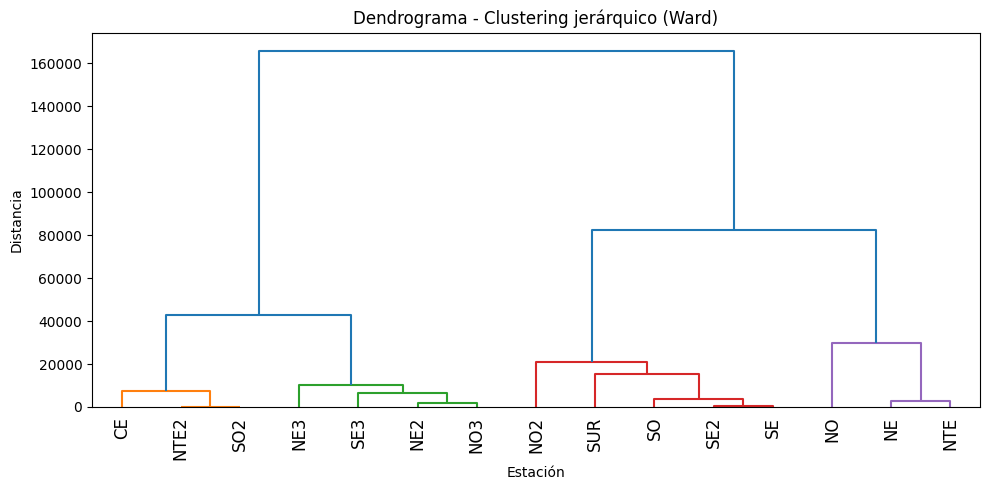

   estacion  poblacion_2km  cluster_k3
8        CE          34246           1
11      SO2          40465           1
7      NTE2          40547           1
2       NE3           8891           2
13      NO3          14672           2
4       NE2          16510           2
0       SE3          21053           2
5       SUR          57242           3
3        SE          68557           3
1       SE2          68913           3
12       SO          71818           3
14      NO2          83200           3
9       NTE         102429           4
6        NE         105412           4
10       NO         129539           4

Archivo guardado: clusters_hierarquicos_estaciones.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

df = pd.read_csv("poblacion_por_estacion_2km.csv")

# --- 2) Preparar matriz de características (solo población) ---
X = df[['poblacion_2km']].values  # forma (n, 1)

# --- 3) Clustering jerárquico (Ward + euclídea) ---
Z = linkage(X, method='ward', metric='euclidean')

# --- 4) Dibujar dendrograma ---
plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    labels=df['estacion'].tolist(),
    leaf_rotation=90,
    color_threshold=Z[-(k-1), 2],  # este truco colorea justo en el punto que genera k clusters
)
plt.title('Dendrograma - Clustering jerárquico (Ward)')
plt.xlabel('Estación')
plt.ylabel('Distancia')
plt.tight_layout()
plt.show()

# --- 5) Asignar clústers cortando el dendrograma ---
# Opción por número de clústers:
k = 4
labels_k = fcluster(Z, t=k, criterion='maxclust')

# (Opcional) Opción por altura (distancia) de corte:
# h = 40000
# labels_h = fcluster(Z, t=h, criterion='distance')

# Guardar resultados con k=3
df_out = df.copy()
df_out['cluster_k3'] = labels_k
df_out = df_out.sort_values(['cluster_k3', 'poblacion_2km'])


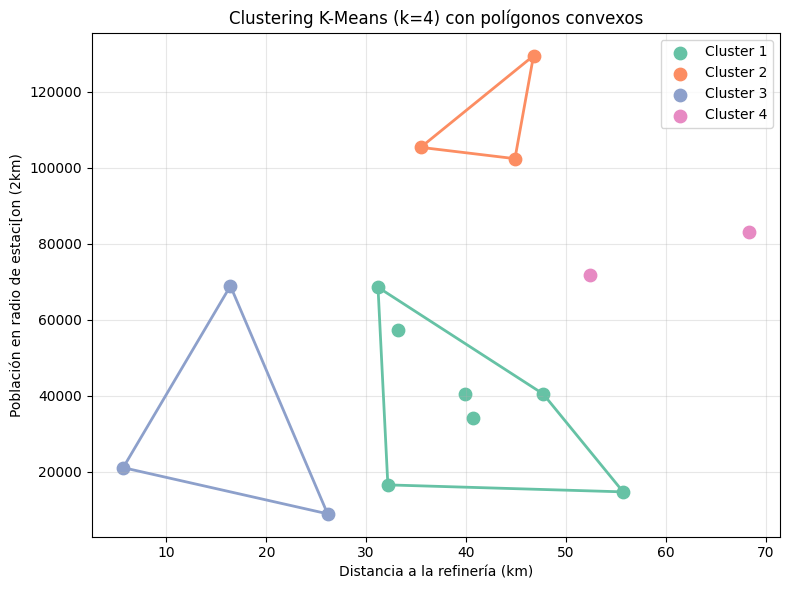

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

df = pd.read_csv("estaciones_poblacion_distancia.csv")

# --- 2. Seleccionar variables e imprimir ---
X = df[['distance_km', 'poblacion_2km']].values

# --- 3. Estandarizar variables ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Aplicar KMeans con k = 4 ---
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# --- 5. Agregar etiquetas al DataFrame ---
df['cluster_k4'] = labels + 1  # de 1 a 4

plt.figure(figsize=(8, 6))
colors = plt.cm.Set2.colors

for i in range(1, k + 1):
    cluster_data = df[df['cluster_k4'] == i]
    x = cluster_data['distance_km'].values
    y = cluster_data['poblacion_2km'].values
    plt.scatter(x, y, label=f'Cluster {i}', s=80, color=colors[i - 1])

    if len(cluster_data) >= 3:
        points = np.column_stack((x, y))
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_points = np.append(hull_points, [hull_points[0]], axis=0)
        plt.plot(hull_points[:, 0], hull_points[:, 1], color=colors[i - 1], linewidth=2)

plt.xlabel('Distancia a la refinería (km)')
plt.ylabel('Población en radio de estaci[on (2km)')
plt.title('Clustering K-Means (k=4) con polígonos convexos')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()